In [194]:
# %pip install mlxtend

In [205]:
# Notebook 1 - Data Preparation
from data_preparation_pipeline import FinancialMLPipeline

# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Machine Learning Packages
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import xgboost as xgb
import lightgbm as lgb
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


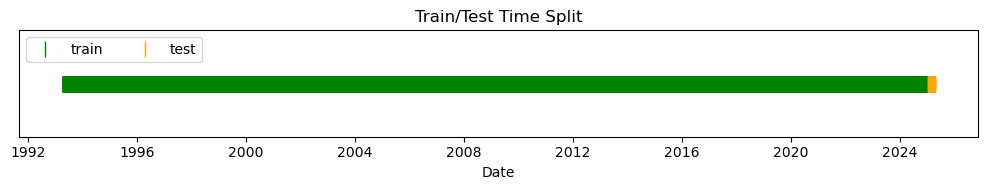

In [196]:
pipeline = FinancialMLPipeline()
df_full = pipeline.run(buy_threshold=0.005,sell_threshold=0.001,test_start='2025-01-20')

Split dataset.

In [197]:
X_tr, y_tr = pipeline.get_X_y(df_full,set_name='train')
X_ts, y_ts = pipeline.get_X_y(df_full,set_name='test')

# Scale for required models
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_ts_scaled = scaler.transform(X_ts)

Filter best features using greedy algorithm to remove noise/multicollinearity.

In [198]:
## SLOW
# sfs = SFS(RandomForestClassifier(n_estimators=100),
#           k_features=10,
#           forward=True,
#           floating=False,
#           scoring='accuracy',
#           cv=5)

## MUCH faster
sfs = SFS(LogisticRegression(max_iter=1000),
          k_features=10,
          forward=True,
          floating=False,
          scoring='accuracy',
          cv=3,
          n_jobs=-1)

sfs.fit(X_tr_scaled, y_tr)
selected_features = [X_tr.columns[int(i)] for i in sfs.k_feature_names_]


In [199]:
print(f'selected features = {selected_features}')

selected features = ['Lag1_VIX', 'RSI', 'MACD', 'Stoch_Osc', 'ATR', 'Volume_Change', 'Log_Return', 'Daily_Range', 'Body', 'Gap']


Train models.

In [200]:
X_tr_sub = X_tr[selected_features]
X_ts_sub = X_ts[selected_features]

X_tr_sub_scaled = scaler.fit_transform(X_tr_sub)
X_ts_sub_scaled = scaler.transform(X_ts_sub)

In [ ]:
# Multinomial Regression
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lr.fit(X_tr_sub_scaled, y_tr)
lr_probs = lr.predict_proba(X_ts_sub_scaled)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
rf.fit(X_tr_sub, y_tr)
rf_probs = rf.predict_proba(X_ts_sub)

# XGBoost
label_map = {-1: 0, 0: 1, 1: 2} # Convert labels from [-1, 0, 1] → [0, 1, 2]
y_tr_xgb = y_tr.map(label_map)
y_val_xgb = y_ts.map(label_map)

xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.05,
                              objective='multi:softprob', use_label_encoder=False, eval_metric='mlogloss')

xgb_model.fit(X_tr_sub, y_tr_xgb)
xgb_probs = xgb_model.predict_proba(X_ts_sub)

# LightGBM
lgb_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.05, max_depth=3)
lgb_model.fit(X_tr_sub, y_tr)
lgb_probs = lgb_model.predict_proba(X_ts_sub)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 7979, number of used features: 10
[LightGBM] [Info] Start training from score -0.920876
[LightGBM] [Info] Start training from score -1.157726
[LightGBM] [Info] Start training from score -1.246080
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Ensemble w/ weighted average of soft labels -> round to hard label/signal.

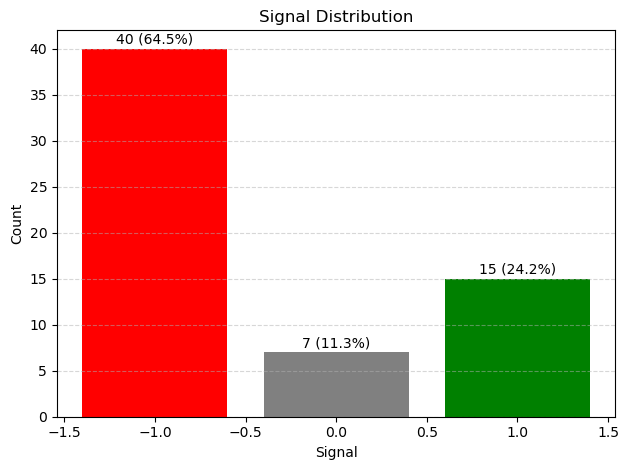

In [202]:
w_lr  = 0.25
w_rf  = 0.25
w_xgb = 0.25
w_lgb = 0.25

assert abs(w_lr + w_rf + w_xgb + w_lgb - 1.0) < 1e-6, 'does not sum to 1'

ensemble_probs = (w_lr  * lr_probs + w_rf  * rf_probs + w_xgb * xgb_probs + w_lgb * lgb_probs)

class_labels = np.array([-1, 0, 1])
signals_val = class_labels[np.argmax(ensemble_probs, axis=1)]

unique, counts = np.unique(signals_val, return_counts=True)
distribution = dict(zip(unique, counts))

# Plot
labels = sorted(distribution.keys())
counts = [distribution[k] for k in labels]

color_map = {-1: 'red', 0: 'grey', 1: 'green'}
colors = [color_map[k] for k in labels]

plt.bar(labels, counts, color=colors)
total = sum(counts)
for x, count in zip(labels, counts):
    percent = 100 * count / total
    plt.text(x, count + 0.2, f'{count} ({percent:.1f}%)', ha='center', va='bottom')
plt.title('Signal Distribution')
plt.xlabel('Signal')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('ensemble_signal_distribution.png')
plt.show()

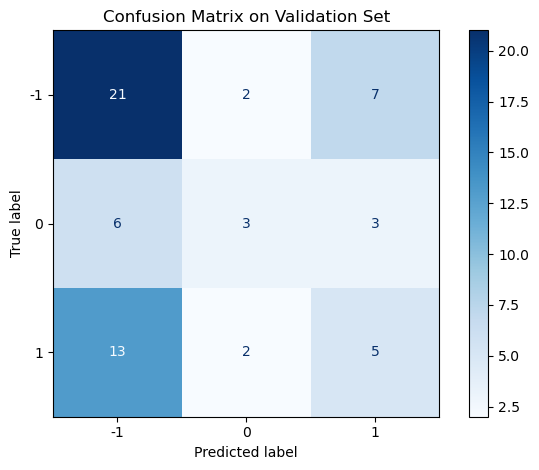

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_ts, signals_val, labels=[-1, 0, 1])

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 0, 1])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix on Validation Set')
plt.grid(False)
plt.tight_layout()
plt.show()


Backtest on the validation set and determine if this is a model I want to "trade" on the test set.

To accurately evaluate the performance of the machine learning-based trading strategy, we define a set of clear assumptions about how the strategy interacts with the market. These assumptions impact how we calculate PnL (profit and loss), manage positions, and interpret results.

**Signal-Driven Daily Trading**
Each model prediction (signal ∈ {-1, 0, 1}) represents a trading action for that day:

- 1 = Buy and hold for one day (go long)

- -1 = Short and cover the same day (go short)

- 0 = Do nothing (flat)

Trades are executed at the open and closed at the close on the same day. No overnight holding, compounding, or carryover of positions across days. This approach assumes a daily reset of positions based on the signal.

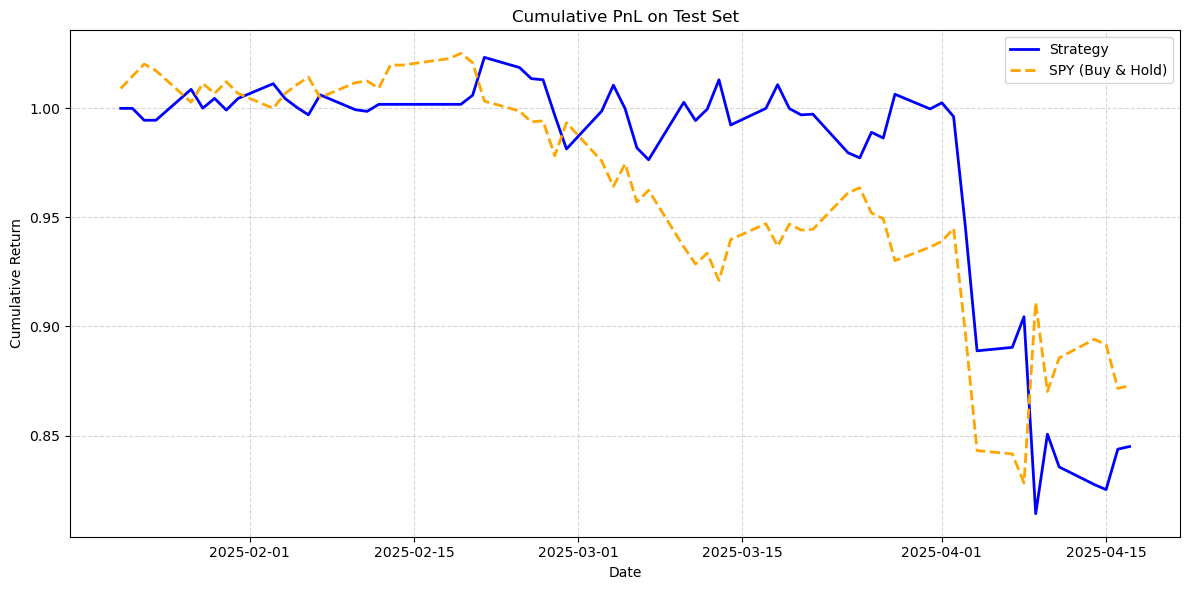

In [204]:
returns_val = df_full.loc[X_ts.index, 'Log_Return'].values
dates_val = X_ts.index
dates = df_full.loc[dates_val,'Date']

strategy_returns = signals_val * returns_val # Strategy returns = signal × return
cumulative_strategy = (strategy_returns + 1).cumprod()
cumulative_market = (returns_val + 1).cumprod()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(dates, cumulative_strategy, label='Strategy', color='blue', linewidth=2)
plt.plot(dates, cumulative_market, label='SPY (Buy & Hold)', color='orange', linestyle='--', linewidth=2)
plt.title('Cumulative PnL on Test Set')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('cumulative_pnl')
plt.show()

Model performs rather poorly.  Future work includes validating the hyperparameters and engineering more relevant features (potentially using api to pull in news sources and conducting nlp) as well as adding more models to the ensemble to reduce variance.